In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle

In [2]:
#load data and correct dtypes
df_full = pd.read_csv('C:/Users/yiyan/Documents/ds_gd_project/clean_data_for_modeling.csv')

for col in ['python', 'rstudio', 'sql', 'aws','pytorch', 'sas', 'excel']:
    df_full[col] = df_full[col].apply(lambda x: 'yes' if x ==1 else 'no')

df_full = df_full.astype('category')
df_full[['average salary']] = df_full[['average salary']].astype('int64')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   average salary     1027 non-null   int64   
 1   job title          1027 non-null   category
 2   seniority          1027 non-null   category
 3   location           1027 non-null   category
 4   company name       1027 non-null   category
 5   size               1027 non-null   category
 6   type of ownership  1027 non-null   category
 7   python             1027 non-null   category
 8   rstudio            1027 non-null   category
 9   sql                1027 non-null   category
 10  aws                1027 non-null   category
 11  pytorch            1027 non-null   category
 12  sas                1027 non-null   category
 13  excel              1027 non-null   category
dtypes: category(13), int64(1)
memory usage: 40.6 KB


In [3]:
df_full.head(5)

,average salary,job title,seniority,location,company name,size,type of ownership,python,rstudio,sql,aws,pytorch,sas,excel
0,94500,data analyst,unspecified,Waterloo,Ontario Teachers Insurance Plan,501 to 1000 employees,Non-profit Organisation,no,no,yes,no,no,no,yes
1,94500,data scientist,unspecified,Toronto,AIR MILES,501 to 1000 employees,Company - Private,yes,no,yes,yes,no,no,no
2,94500,data scientist,unspecified,Toronto,Rubikloud Technologies,51 to 200 employees,Company - Private,yes,no,yes,yes,no,no,no
3,94500,data scientist,unspecified,Toronto,Nielsen,10000+ employees,Company - Public,yes,no,yes,yes,no,no,yes
4,94500,data analyst,unspecified,Edmonton,ATB Financial,5001 to 10000 employees,Company - Private,yes,no,yes,yes,no,yes,yes


In [4]:
# choose a subset of predictor variables
df = df_full[['average salary', 'job title',  'location', 'size', 'type of ownership', 'python', 'rstudio', 'sql', 'aws','pytorch', 'sas', 'excel']]

### Multivariate Linear model

In [5]:
# create dummy variables with baseline dropped for linear models
dum_drop = pd.get_dummies(df, drop_first = True)


In [6]:
#split data to train test sets 
from sklearn.model_selection import train_test_split

X = dum_drop.drop('average salary', axis =1)
y = dum_drop['average salary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1215)

In [7]:
X_train.head(2)

,job title_business intelligent analyst,job title_data analyst,job title_data engineer,job title_data scientist,job title_machine learning engineer,job title_manager analytics,job title_research scientist,job title_statistician,location_Anjou,location_Boucherville,...,type of ownership_Self-employed,type of ownership_Subsidiary or Business Segment,type of ownership_Unknown,python_yes,rstudio_yes,sql_yes,aws_yes,pytorch_yes,sas_yes,excel_yes
542,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
564,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1


In [9]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)
np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 10))

-544677116368008.4

In [23]:
lm.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [36]:
from sklearn.model_selection import GridSearchCV
lm_lasso = Lasso(normalize = False)
alpha = {'alpha' : np.arange(100, 300, 5)}
gs_lasso = GridSearchCV(lm_lasso,alpha,scoring='neg_mean_absolute_error',cv= 10)
gs_lasso.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225,
       230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290,
       295])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [37]:
print(gs_lasso.best_score_)
gs_lasso.best_estimator_

-16784.909518590495


Lasso(alpha=225, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Random Forest

In [16]:
dum = pd.get_dummies(df, drop_first = False)
X2 = dum.drop('average salary', axis =1)
y2 = dum['average salary'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=1215)

In [56]:
X_train2.head(2)

,job title_actuarial analyst,job title_business intelligent analyst,job title_data analyst,job title_data engineer,job title_data scientist,job title_machine learning engineer,job title_manager analytics,job title_research scientist,job title_statistician,location_114 Mile House,...,sql_no,sql_yes,aws_no,aws_yes,pytorch_no,pytorch_yes,sas_no,sas_yes,excel_no,excel_yes
542,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
564,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(n_estimators = 200,random_state = 4612) 
parameters = {'criterion':('mae','mse'), 'max_features':('auto','sqrt')}
gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv= 10)
gs.fit(X_train2,y_train2)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=4612,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [18]:
print(gs.best_score_)
gs.best_estimator_

-17745.368241257715


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=4612, verbose=0, warm_start=False)

In [ ]:
### SVM

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
svr =  svm.SVR()

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
gs_svr = GridSearchCV(svr, param_grid, scoring= 'neg_mean_absolute_error',cv= 10, refit=True)
gs_svr.fit(X_train2, y_train2)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [21]:
print(gs_svr.best_score_)
gs_svr.best_estimator_

-16288.96012737924


SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
## Test models on testset

In [38]:
# predict on testset


y_tpred_lasso = gs_lasso.best_estimator_.predict(X_test)
y_tpred_rf = gs.best_estimator_.predict(X_test2)
y_tpred_svr = gs_svr.best_estimator_.predict(X_test2)

In [39]:
from sklearn.metrics import mean_absolute_error

print('test error(MAE) for Lasso model is %d'%(mean_absolute_error(y_test, y_tpred_lasso)))
print('test error(MAE) for Random Forest model is % d'%(mean_absolute_error(y_test2, y_tpred_rf)))
print('test error(MAE) for Support Vector Regressor model is %d'%(mean_absolute_error(y_test2, y_tpred_svr)))

test error(MAE) for Lasso model is 16445
test error(MAE) for Random Forest model is  18267
test error(MAE) for Support Vector Regressor model is 16729


Text(0.5, 0.98, 'pred vs true')

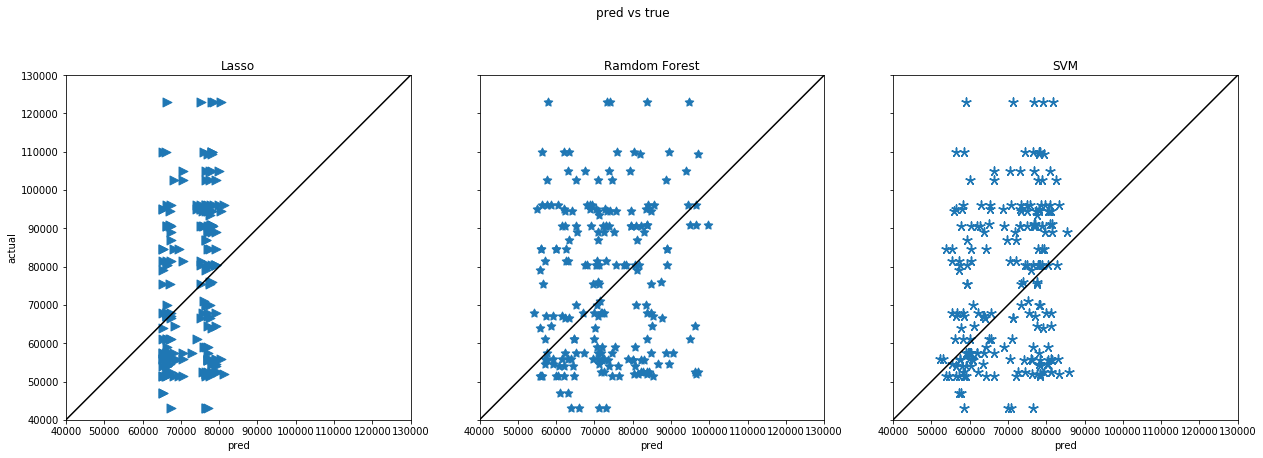

In [40]:

fig, axs = plt.subplots(1, 3,figsize=(21, 7),sharey= True,sharex = True)
axs[0].scatter(y_tpred_lasso, y_test, s=80, marker=">" )
axs[0].set_title('Lasso')
axs[0].set_xlim(40000, 130000)
axs[0].set_ylim(40000, 130000)
axs[0].set_aspect('equal', adjustable='box')
axs[0].plot([40000, 130000], [40000, 130000], 'k-')
axs[1].scatter(y_tpred_rf, y_test2,s=80, marker=(5, 1))
axs[1].set_aspect('equal', adjustable='box')
axs[1].plot([40000, 130000], [40000, 130000], 'k-')
axs[1].set_title('Ramdom Forest')
axs[2].scatter(y_tpred_svr, y_test2,s=80, marker=(5, 2))
axs[2].set_aspect('equal', adjustable='box')
axs[2].plot([40000, 130000], [40000, 130000], 'k-')
axs[2].set_title('SVM')
axs[0].set_ylabel('actual')
axs[0].set_xlabel('pred');axs[1].set_xlabel('pred');axs[2].set_xlabel('pred');
fig.suptitle('pred vs true')


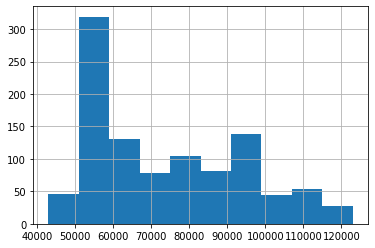

In [41]:
#looking for reasons why models ony predict sal bw 50-90 well
df_full['average salary'].hist()

In [62]:
#predict on a new example with svm model
example = [
    {'job title':'data scientist', 'location':'Toronto', 'size':'10000+ employees', 'type of ownership':'Company-Private','python':'yes', 'rstudio':'no', 'sql' : 'yes', 'aws':'yes', 'pytorch':'no', 'sas':'no', 'excel':'yes'}

]
example = pd.DataFrame(example)
example = pd.get_dummies(example)
example= example.reindex(columns = X_train2.columns,fill_value = 0)

list(gs_svr.best_estimator_.predict(example))


[79544.72609333399]

In [ ]:
### Save rf and svm models for deployment

In [52]:
# Save the models
from sklearn.externals import joblib
joblib.dump(gs.best_estimator_, 'rf_model.pkl')
print('dumped')
joblib.dump(gs_svr.best_estimator_, 'svr_model.pkl')
print('dumped')

dumped
dumped


In [63]:
# Save the models
import joblib
joblib.dump(gs.best_estimator_, 'rf_model.pkl')
print('dumped')
joblib.dump(gs_svr.best_estimator_, 'svr_model.pkl')
print('dumped')

dumped
dumped


In [53]:
# Load the models that were just saved and test them. They worked.
rf_mod = joblib.load('rf_model.pkl')
svr_mod = joblib.load('svr_model.pkl')

print(rf_mod.predict(example))
print(svr_mod.predict(example))

[79311.25]
[79544.72609333]


In [60]:
X_train2.columns

Index(['job title_actuarial analyst', 'job title_business intelligent analyst',
       'job title_data analyst', 'job title_data engineer',
       'job title_data scientist', 'job title_machine learning engineer',
       'job title_manager analytics', 'job title_research scientist',
       'job title_statistician', 'location_114 Mile House',
       ...
       'sql_no', 'sql_yes', 'aws_no', 'aws_yes', 'pytorch_no', 'pytorch_yes',
       'sas_no', 'sas_yes', 'excel_no', 'excel_yes'],
      dtype='object', length=110)

In [64]:
# Save the dummy columns of X_train 
model_columns = list(X_train2.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")

Models columns dumped!
